In [3]:
from plotting_utils import plot_movement_trajectory_with_layout
import os

heartbeat_dir = os.path.join('EK_P02', 'Electrophysiology', 'VR', 'BBT-BIO-AAB023-2024-06-18_12-53-55')
heartbeat_path = os.path.join(heartbeat_dir, 'ExG [1].csv')
utc_path = os.path.join(heartbeat_dir, 'UTC.csv')

movement_dir = os.path.join('EK_P02', 'VR', 'pilot final', 'S001', 'trackers')
movement_path = os.path.join(movement_dir, 'camera_movement_T007.csv')


time     0.011115
pos_x    0.002278
pos_y    0.000702
pos_z    0.003513
rot_x    0.218472
rot_y    0.326194
rot_z    0.113106
dist     0.004757
speed    0.429699
dtype: float64
time     0.011109
pos_x    0.003485
pos_y    0.000964
pos_z    0.005439
rot_x    0.264048
rot_y    0.442656
rot_z    0.137150
dist     0.007270
speed    0.656873
dtype: float64
(13639, 2)


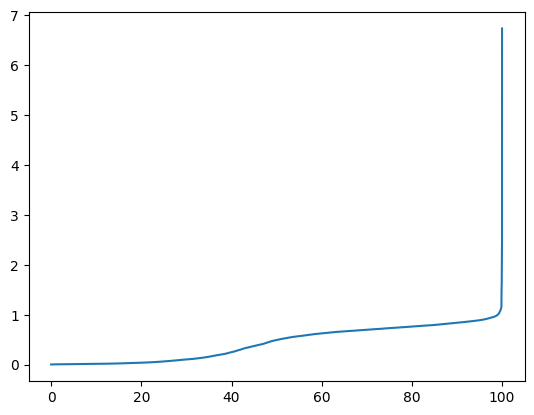

In [4]:
from calculations import calculate_total_rotation, df_diff
import pandas as pd
import numpy as np
from geometry_utils import get_ellipsoid_axes, get_focus, get_eccentricity, get_focus_and_eccentricity

movement_data = pd.read_csv(movement_path).drop("timestamp", axis=1)
diff_frame = df_diff(movement_data)
diff_frame["dist"] = np.sqrt(diff_frame["pos_x"].pow(2) + diff_frame["pos_y"].pow(2) + diff_frame["pos_z"].pow(2))
diff_frame["speed"] = diff_frame["dist"] / diff_frame["time"]
print(diff_frame.mean())
import matplotlib.pyplot as plt
y = np.sort(diff_frame["speed"])
x = 100*np.arange(len(y))/len(y)

print(diff_frame[diff_frame["speed"] > 0.2].mean())
plt.plot(x,y)

points = np.transpose(np.stack((movement_data['pos_x'], movement_data['pos_z'])), axes=[1,0])
print(points.shape)

#print(get_focus_and_eccentricity(points))


In [5]:
import numpy as np
from geometry_utils import mean_edge_distance, mean_center_distance

center_point = np.array((-7,5))
corner_points = np.array([(-4,2),(-9,2),(-9,9),(-4,9)])

print(mean_center_distance(points, center_point))
print(mean_edge_distance(points, corner_points))

2.211453725763196
0.9913892569888263


In [4]:
print(movement_data)

           time     pos_x     pos_y     pos_z      rot_x     rot_y       rot_z
0      481.4744 -6.450725  1.610676  5.976768   18.69923  191.0628  356.788400
1      481.5030 -6.449114  1.612531  5.977763   17.93752  190.3711  357.026700
2      481.5665 -6.445739  1.616737  5.979550   16.17531  188.8127  357.691100
3      481.5835 -6.437787  1.626127  5.982200   10.59442  184.2375  359.381900
4      481.6032 -6.435087  1.628952  5.983236    8.90156  182.7538  359.892800
...         ...       ...       ...       ...        ...       ...         ...
15522  669.9332 -6.410432  1.643844  7.399132  344.49090  247.2068    0.693032
15523  669.9443 -6.410322  1.643813  7.399046  344.47230  247.1951    0.684410
15524  669.9551 -6.410256  1.643723  7.398874  344.46620  247.1842    0.687550
15525  669.9661 -6.410257  1.643744  7.398837  344.46520  247.1560    0.699657
15526  669.9771 -6.410212  1.643714  7.398784  344.44630  247.1548    0.717355

[15527 rows x 7 columns]


In [11]:
from biosppy.signals.tools import filter_signal
import pandas as pd
import biosppy.signals.ecg as ecg
import numpy as np
from shapely.geometry import Point, LineString
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
#from calculations import calculate_accelerations_t7_t15, calculate_speeds_t7_t15


def get_segment(data, start_time, end_time, timestamps):
    segment_points = data[np.logical_and(timestamps >= start_time, 
                                         timestamps < end_time)]
    return segment_points
    
def get_segment_mean_center_dist(segment, center_point):
    # transform points into np array of dimension [N, 2]
    points = np.transpose(np.stack((segment['pos_x'], segment['pos_z'])), axes=[1,0])
    
    center_dist = mean_center_distance(points, center_point)
    return center_dist

def get_segment_mean_edge_dist(segment, corner_points):
    points = np.transpose(np.stack((segment['pos_x'], segment['pos_z'])), axes=[1,0])
    return mean_edge_distance(points, corner_points)

def get_segment_mean_area_covered(segment):
    empty_room_coords=np.array([[-8.30, 8.87], [-4.70, 8.87], [-4.70, 1.87], [-8.30, 1.87]])
    empty_room_coords=Polygon(empty_room_coords)
    trajectory_line = LineString(zip(segment['pos_x'], segment['pos_z']))
    trajectory_area = trajectory_line.buffer(0.1)
    total_intersection = trajectory_area.intersection(empty_room_coords)
    total_area = empty_room_coords.area
    percentage_covered = (total_intersection.area / total_area) * 100
    return percentage_covered
'''
def get_max_distance(segment):
    # Stack pos_x and pos_z into points array
    points = np.transpose(np.stack((segment['pos_x'], segment['pos_z'])), axes=[1,0])
    
    # Calculate maximum distance between any two points
    max_dist = 0
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            dist = np.sqrt(np.sum((points[i] - points[j]) ** 2))
            max_dist = max(max_dist, dist)
    return max_dist
'''

def get_max_distance(segment):
    # Stack pos_x and pos_z into points array
    points = np.transpose(np.stack((segment['pos_x'], segment['pos_z'])), axes=[1,0])
    
    # Find min and max coordinates
    min_coords = np.min(points, axis=0)  # [min_x, min_z]
    max_coords = np.max(points, axis=0)  # [max_x, max_z]
    
    # Calculate maximum possible distance
    max_dist = np.sqrt(np.sum((max_coords - min_coords) ** 2))
    
    return max_dist

def get_segment_stops_duration(movement_segment, stop_threshold=0.01, stop_duration_threshold=0.5):
    # Calculate speeds within the segment
    diff_df = movement_segment.drop('timestamp', axis=1).diff(axis=0)
    diff_df["dist"] = np.sqrt(diff_df["pos_x"].pow(2) + diff_df["pos_y"].pow(2) + diff_df["pos_z"].pow(2))
    speeds = diff_df['dist']/diff_df['time']
    
    # Get time values
    time = movement_segment['time'].to_numpy()
    
    stops = []
    current_stop_start = None

    for i, speed in enumerate(speeds):
        if speed < stop_threshold:
            if current_stop_start is None:
                current_stop_start = time[i]
        else:
            if current_stop_start is not None:
                stop_duration = time[i] - current_stop_start
                if stop_duration >= stop_duration_threshold:
                    stops.append(stop_duration)
                current_stop_start = None

    # Check for ongoing stop at the end
    if current_stop_start is not None:
        stop_duration = time[-1] - current_stop_start
        if stop_duration >= stop_duration_threshold:
            stops.append(stop_duration)
    
    # Return total duration of stops in the segment
    return sum(stops) if stops else 0


def get_segment_stops_count(movement_segment, stop_threshold=0.01, stop_duration_threshold=0.5):
    """Calculate number of stops within a segment of trajectory."""
    # Calculate speeds within the segment
    diff_df = movement_segment.drop('timestamp', axis=1).diff(axis=0)
    diff_df["dist"] = np.sqrt(diff_df["pos_x"].pow(2) + diff_df["pos_y"].pow(2) + diff_df["pos_z"].pow(2))
    speeds = diff_df['dist']/diff_df['time']
    
    # Get time values
    time = movement_segment['time'].to_numpy()
    
    stops_count = 0
    current_stop_start = None

    for i, speed in enumerate(speeds):
        if speed < stop_threshold:
            if current_stop_start is None:
                current_stop_start = time[i]
        else:
            if current_stop_start is not None:
                stop_duration = time[i] - current_stop_start
                if stop_duration >= stop_duration_threshold:
                    stops_count += 1  
                current_stop_start = None

    # Check for ongoing stop at the end
    if current_stop_start is not None:
        stop_duration = time[-1] - current_stop_start
        if stop_duration >= stop_duration_threshold:
            stops_count += 1

    return stops_count  

def get_segment_heart_rate(segment, sampling_rate=256):
    r_peaks = find_r_peaks(segment, sampling_rate)
    rr_intervals = np.diff(r_peaks) / sampling_rate
    bpm = 60 / np.mean(rr_intervals)
    return bpm

def preprocess_ecg(signal, sampling_rate):
    #denoised_signal = cwt_denoise(signal)
    # Preprocess the ECG signal
    # Bandpass filter the ECG signal (0.5-40 Hz)
    filtered_signal = filter_signal(signal,
    #                                denoised_signal,
                                    ftype='FIR',
                                    band='bandpass',
                                    order=int(0.3 * sampling_rate),
                                    frequency=[0.1, 40],
                                    sampling_rate=sampling_rate) # check if they are the same and hf is getting filtered
    filtered_signal = filtered_signal[0]
    #filtered_signal = filtered_signal.reshape(-1)
    return filtered_signal

def find_r_peaks(signal, sampling_rate):
    # Find R peaks using the Pan-Tompkins algorithm
    r_peaks = ecg.engzee_segmenter(signal, sampling_rate=sampling_rate)[0]
    return r_peaks

def filter_rr_intervals(rr_intervals):
    # Remove RR intervals that are physiologically impossible
    # For example, intervals < 300ms or > 2000ms
    return rr_intervals[(rr_intervals >= 0.3) & (rr_intervals <= 2.0)]
'''
def calculate_rmssd(r_peaks, sampling_rate):
    # Calculate the RR intervals
    rr_intervals = np.diff(r_peaks) / sampling_rate
    
    # Calculate the successive differences of RR intervals
    rr_diff = np.diff(rr_intervals)
    
    # Calculate RMSSD
    rmssd = np.sqrt(np.mean(rr_diff ** 2))
    return rmssd
'''
def calculate_rmssd(r_peaks, sampling_rate):
    # Calculate the RR intervals in milliseconds
    rr_intervals_ms = np.diff(r_peaks) / sampling_rate * 1000
    
    # Calculate the successive differences of RR intervals
    rr_diff_ms = np.diff(rr_intervals_ms)
    
    # Square each value in rr_diff_ms
    rr_diff_squared = rr_diff_ms ** 2
    
    # Calculate the average of rr_diff_squared
    rr_diff_mean = np.mean(rr_diff_squared)
    
    # Calculate the square root of rr_diff_mean to get RMSSD
    rmssd = np.sqrt(rr_diff_mean)
    
    return rmssd

def get_segment_rmssd(signal_segment, sampling_rate=256):
    r_peaks = find_r_peaks(signal_segment, sampling_rate)
    rmssd = calculate_rmssd(r_peaks, sampling_rate)
    return rmssd

def get_segment_speed(movement_data):    
    diff_df = movement_data.drop('timestamp', axis=1).diff(axis=0)
    diff_df["dist"] = np.sqrt(diff_df["pos_x"].pow(2) + diff_df["pos_y"].pow(2) + diff_df["pos_z"].pow(2))
    speed = diff_df['dist']/diff_df['time']
    return np.mean(speed)


def get_segment_acceleration(movement_data):
    diff_df = movement_data.drop('timestamp', axis=1).diff(axis=0)
    diff_df["dist"] = np.sqrt(diff_df["pos_x"].pow(2) + diff_df["pos_y"].pow(2) + diff_df["pos_z"].pow(2))
    speeds = diff_df['dist']/diff_df['time']
    
    
    # Calculate acceleration as change in speed over time
    acc = speeds.diff() / diff_df['time']
    return np.mean(acc)

movement_data = pd.read_csv(movement_path)
heartrate_data = pd.read_csv(heartbeat_path)
utc_df = pd.read_csv(utc_path)
timestamp_diff = (utc_df['utc_timestamp']-utc_df['steady_timestamp']).astype(int).to_numpy()[0]

heartrate_timestamps = ((heartrate_data['steady_timestamp'] + timestamp_diff)/1e6).astype(int).to_numpy()

ecg_signal = heartrate_data['ExG [1]-ch1']
signal = preprocess_ecg(ecg_signal, 250)
r_peaks = find_r_peaks(signal, 250)
rmssd = calculate_rmssd(r_peaks, 250)


segment_length=10
step_size=1

# heart rate data 
#heart_rate_data

timestamps = pd.to_datetime(movement_data['timestamp']).apply(lambda x: x.timestamp()).astype(int).to_numpy()

start_time = np.floor(np.min(timestamps))

end_time = start_time + 90 #for elevated platofrm it should be bigger than that
segment_starts = np.arange(start_time, end_time-segment_length+1, step=step_size)
segment_ends = segment_starts + segment_length

segment_mean_center_dist = np.zeros(len(segment_starts))
segment_hr = np.zeros(len(segment_starts))
segment_mean_speed = np.zeros(len(segment_starts))
segment_rmssd = np.zeros(len(segment_starts))
segment_mean_edge_dist = np.zeros(len(segment_starts))
segment_mean_acc= np.zeros(len(segment_starts))
segment_mean_area_covered=np.zeros(len(segment_starts))
segment_stops_duration = np.zeros(len(segment_starts))
segment_stops_count= np.zeros(len(segment_starts))
segment_max_distance = np.zeros(len(segment_starts))

for idx, (start, end) in enumerate(zip(segment_starts, segment_ends)):
    movement_segment = get_segment(movement_data, start, end, timestamps)
    center_dist = get_segment_mean_center_dist(movement_segment, center_point)    
    segment_mean_center_dist[idx] = center_dist
    
    edge_dist = get_segment_mean_edge_dist(movement_segment, corner_points)
    segment_mean_edge_dist[idx] = edge_dist
    
    speed = get_segment_speed(movement_segment)
    segment_mean_speed[idx] = speed

    acc=get_segment_acceleration(movement_segment)
    segment_mean_acc[idx]= acc
    
    area_covered = get_segment_mean_area_covered(movement_segment)
    segment_mean_area_covered[idx] = area_covered

    #segment_hr = get_segment(signal, start+5, end+5, heartrate_timestamps)
    hr_segment = get_segment(signal, start, end, heartrate_timestamps)
    hr=get_segment_heart_rate(hr_segment)
    segment_hr[idx] = hr

    stops_duration = get_segment_stops_duration(movement_segment, stop_threshold=0.10, stop_duration_threshold=2.0)
    segment_stops_duration[idx] = stops_duration

    stops_count= get_segment_stops_count(movement_segment, stop_threshold=0.10, stop_duration_threshold=2.0)
    segment_stops_count[idx] = stops_count

    distance_max = get_max_distance(movement_segment)
    segment_max_distance[idx] = distance_max
    
    #rmssd = get_segment_rmssd(segment_hr)
    #segment_rmssd[idx] = rmssd 
    


In [7]:
center_dist

np.float64(1.9319588421157257)

In [12]:
segment_max_distance

array([0.14784699, 0.14564093, 0.12396548, 0.12396548, 0.12396548,
       0.12396548, 0.11722913, 0.07713344, 0.08034165, 0.08794914,
       0.08794914, 0.09136139, 0.10582957, 0.32267264, 0.9201376 ,
       1.4745622 , 2.04166707, 2.69255907, 3.36953801, 4.09688053,
       4.83214754, 5.39435795, 5.88118303, 6.02158582, 5.64248722,
       5.14731321, 4.49561105, 3.89332164, 3.4571349 , 3.31345565,
       3.20983847, 2.92372498, 2.89550506, 2.98139954, 3.17348154,
       3.60214386, 4.08816669, 4.23931012, 4.51617178, 5.03905107,
       5.5099091 , 5.97014348, 6.2321751 , 6.36761211, 6.05675409,
       5.26123165, 4.48100247, 3.79850612, 3.97121624, 4.4915454 ,
       5.05100061, 5.64195471, 6.16407354, 5.97836909, 5.69177546,
       5.14910771, 4.40937117, 3.7085606 , 3.94328958, 4.62020779,
       5.22407726, 5.71053382, 5.94854163, 5.83996176, 5.38859237,
       4.80972947, 4.16689179, 3.7682687 , 4.42779542, 5.13011641,
       5.66174031, 5.91049901, 5.89678315, 5.8080205 , 5.44532

In [7]:
segment_mean_area_covered

array([0.26592779, 0.26414364, 0.2478777 , 0.2473808 , 0.24390933,
       0.2434045 , 0.23631743, 0.19398049, 0.19544956, 0.20112739,
       0.20549172, 0.20844406, 0.23031594, 0.45041657, 0.95052333,
       1.45195738, 1.97737224, 2.54030431, 3.11922412, 3.71480089,
       4.33015463, 4.82053803, 5.10074511, 4.86091059, 4.35588508,
       3.84512975, 3.30048681, 2.72508357, 2.22928447, 2.16384512,
       1.61028663, 1.11946531, 0.73422587, 0.68396018, 0.68396018,
       0.70752348, 1.35632065, 1.94433503, 2.59681045, 2.75591017,
       3.12243829, 3.65997679, 4.15896123, 4.68192011, 5.12987259,
       5.57562936, 5.61552717, 5.60336212, 5.5048308 , 5.43780441,
       5.5401433 , 5.59811637, 5.59843626, 5.45807768, 5.49226509,
       5.62770019, 5.64045703, 5.61854757, 5.65146126, 5.71386386,
       5.63092655, 5.53068549, 5.42296093, 5.20115302, 5.2642679 ,
       5.32280468, 5.36948747, 5.5376377 , 5.5663315 , 5.61074418,
       5.59867641, 5.49449166, 5.62077712, 6.10855835, 6.21411

In [33]:
segment_mean_area_covered

array([0.26592779, 0.26414364, 0.2478777 , 0.2473808 , 0.24390933,
       0.2434045 , 0.23631743, 0.19398049, 0.19544956, 0.20112739,
       0.20549172, 0.20844406, 0.23031594, 0.45041657, 0.95052333,
       1.45195738, 1.97737224, 2.54030431, 3.11922412, 3.71480089,
       4.33015463, 4.82053803, 5.10074511, 4.86091059, 4.35588508,
       3.84512975, 3.30048681, 2.72508357, 2.22928447, 2.16384512,
       1.61028663, 1.11946531, 0.73422587, 0.68396018, 0.68396018,
       0.70752348, 1.35632065, 1.94433503, 2.59681045, 2.75591017,
       3.12243829, 3.65997679, 4.15896123, 4.68192011, 5.12987259,
       5.57562936, 5.61552717, 5.60336212, 5.5048308 , 5.43780441,
       5.5401433 , 5.59811637, 5.59843626, 5.45807768, 5.49226509,
       5.62770019, 5.64045703, 5.61854757, 5.65146126, 5.71386386,
       5.63092655, 5.53068549, 5.42296093, 5.20115302, 5.2642679 ,
       5.32280468, 5.36948747, 5.5376377 , 5.5663315 , 5.61074418,
       5.59867641, 5.49449166, 5.62077712, 6.10855835, 6.21411

In [10]:
segment_stops_duration

array([3.155 , 4.1549, 4.3557, 4.3557, 7.111 , 7.111 , 7.111 , 6.9332,
       5.9338, 4.9326, 2.7553, 2.7553, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    ])

In [11]:
segment_stops_count

array([1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [27]:
segment_hr

array([ 95.88014981, 106.71025746, 108.93617021, 113.18595579,
       122.81449893, 128.53556485, 108.11463047,  83.81991814,
        72.17428449,  68.85085575,  85.4063302 ,  65.16758591,
        67.18091451,  85.92082616,  93.09090909,  95.04950495,
        94.15061296,  95.60165975,  93.37386018,  94.81481481,
       109.62216625, 113.87701701, 112.26139295, 115.2       ,
       115.32613796, 106.66666667, 127.89342215, 129.33440257,
        80.53384175,  80.0347373 ,  93.5770235 , 112.16795984,
        98.69879518,  91.86602871,  81.55752212,  85.33333333,
       103.34735071, 101.84832159, 105.07054297, 100.59762587,
       118.92420538, 123.39957717,  80.84210526,  76.67221298,
       111.84466019, 108.25870647, 112.55172414, 112.66503667,
       117.29903537, 117.20481928, 105.24788392, 113.33333333,
       109.85275557,  97.54763068,  90.04396678,  99.20344456,
       100.        ,  74.17303823,  93.22128852,  63.67572547,
        75.97691674,  81.20374136,  88.85950413, 106.20

In [11]:
segment_hr

array([101.35200646, 105.93103448, 100.40582868, 100.36538205,
        98.29089455, 101.58455932,  94.64603588,  92.34871259,
        99.68741722, 104.90149724, 105.26093832, 104.05094161,
       109.0529136 , 108.1397238 , 106.29757785, 113.00160514,
       110.90252708, 108.45723421, 110.78402564, 109.71428571,
       108.41390332, 114.79514213, 113.49254519, 100.32240133,
       102.83877879, 104.8326552 , 108.83226598, 109.7868961 ,
       108.09719825,  96.31466439,  98.50363403, 107.03039288,
        97.26649077,  97.75656325,  98.40896957, 101.87027457,
       102.03268234,  89.97139354,  88.35852843,  99.31908155,
        97.09751177,  95.93482688,  92.85845709,  96.03831316,
        91.23548046,  90.4496788 ,  91.82941411,  91.73883535,
        85.85802124,  86.34988623,  88.98485846,  88.84584342,
        88.56506356,  92.73799495,  83.5350102 ,  86.66579189,
        88.31127156,  90.89952656,  96.30736393,  95.22754254,
        93.62130648])

In [7]:
segment_mean_speed

array([0.11329448, 0.11795084, 0.13999243, 0.1736402 , 0.18979157,
       0.22877244, 0.28608181, 0.34578391, 0.38185045, 0.42523738,
       0.47521887, 0.49861791, 0.49127885, 0.45781007, 0.45111858,
       0.40498795, 0.34954661, 0.28678656, 0.22852007, 0.20507466,
       0.19700753, 0.17287714, 0.18072142, 0.20644421, 0.22824621,
       0.26515176, 0.32892701, 0.39996241, 0.47579516, 0.53028621,
       0.56612793, 0.60783085, 0.61625893, 0.58562339, 0.58577323,
       0.58725262, 0.57891847, 0.57032006, 0.55448095, 0.53911652,
       0.53398946, 0.53824504, 0.55627624, 0.60556996, 0.59823398,
       0.56376622, 0.52252124, 0.46489145, 0.40981494, 0.36475744,
       0.33705567, 0.3026666 , 0.25363044, 0.27510773, 0.307374  ,
       0.36506832, 0.42018745, 0.48486329, 0.54350058, 0.59103294,
       0.60297414, 0.61929327, 0.63679309, 0.62168024, 0.57715125,
       0.51295313, 0.44620888, 0.38122107, 0.31735817, 0.27539524,
       0.25630589, 0.27438226, 0.30658734, 0.28839054, 0.28369

In [8]:
segment_mean_acc

array([ 1.29495914e-02,  4.51486837e-02,  1.66640372e-02,  7.11841454e-02,
        4.35220358e-02,  3.19930466e-02,  1.17371002e-01,  7.82372348e-02,
        4.35917029e-02,  7.96926353e-02,  8.72236909e-02,  4.27185462e-03,
       -6.60571695e-03,  8.76971168e-03, -4.31731766e-02,  2.72561782e-02,
       -9.30394258e-02, -6.90240734e-02, -3.99687434e-02,  3.96562025e-02,
       -5.32810038e-02, -2.07129992e-02, -1.23944159e-04,  4.87942394e-03,
        7.99985239e-02,  1.88087328e-02,  6.67683074e-02,  7.48652755e-02,
        6.17115810e-02,  5.54169070e-02,  1.28787765e-01,  8.30935628e-02,
        9.05154987e-02,  7.02220720e-02,  9.50427921e-02,  1.06267430e-01,
        9.50848970e-02,  7.53317613e-02,  8.40357119e-02,  3.20419644e-02,
       -3.46853854e-02, -4.47471660e-02, -3.85525315e-02, -2.20656885e-02,
       -1.17580747e-01, -1.55063384e-01, -1.72934684e-01, -1.55518609e-01,
       -1.48744990e-01, -1.26778471e-01, -2.16237881e-02, -5.03539784e-03,
       -3.36624067e-02,  

In [9]:
a=segment_mean_center_dist[0:10]

In [10]:
b=segment_mean_center_dist[1:11]

In [11]:
cross_cor=np.correlate(a,b, mode='full')

In [12]:
cross_cor

array([ 1.48009046,  2.74543795,  3.84023728,  4.81143737,  5.7261347 ,
        6.63554947,  7.57394143,  8.59423367,  9.75707502, 11.08821791,
        9.6364764 ,  8.35000476,  7.20267259,  6.17123615,  5.20854799,
        4.2755226 ,  3.34445413,  2.36444713,  1.266007  ])

In [13]:
segment_mean_center_dist

array([1.16098363, 1.15733921, 1.13980238, 1.10499794, 1.04593423,
       0.96887492, 0.9029084 , 0.89430516, 0.96568366, 1.09389451,
       1.27485903, 1.50074471, 1.77881305, 2.11337497, 2.43495194,
       2.77564023, 3.08634066, 3.32582951, 3.50180397, 3.63028187,
       3.68471817, 3.6851368 , 3.65449123, 3.62408661, 3.60959739,
       3.56212081, 3.44512119, 3.24820178, 3.02370039, 2.81003644,
       2.6263319 , 2.47604988, 2.35154702, 2.25953041, 2.15524784,
       2.03387804, 1.90780426, 1.76233638, 1.61101885, 1.49370916,
       1.4259277 , 1.40870068, 1.43472081, 1.49212689, 1.60986172,
       1.8024847 , 2.05240939, 2.36228484, 2.71140451, 3.03000957,
       3.2950955 , 3.50963777, 3.67018448, 3.74390081, 3.69473723,
       3.55626298, 3.38309979, 3.19612644, 3.0126451 , 2.83650194,
       2.65884376, 2.46686647, 2.29409968, 2.11329564, 1.99087017,
       1.93019471, 1.91256624, 1.90947716, 1.9004176 , 1.86649772,
       1.79441691, 1.68300281, 1.52907527, 1.3907857 , 1.28135

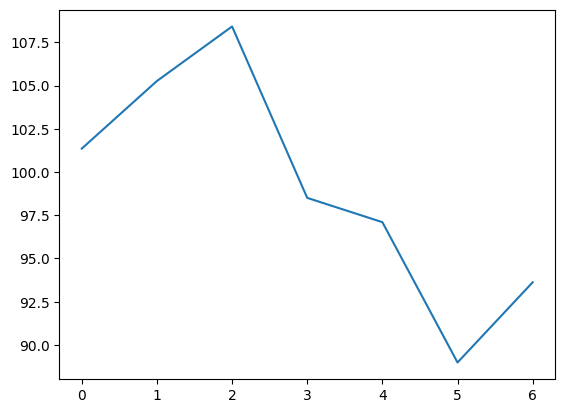

In [ ]:
x=segment_hr
y= np.arange(7)

plt.plot(y,x)

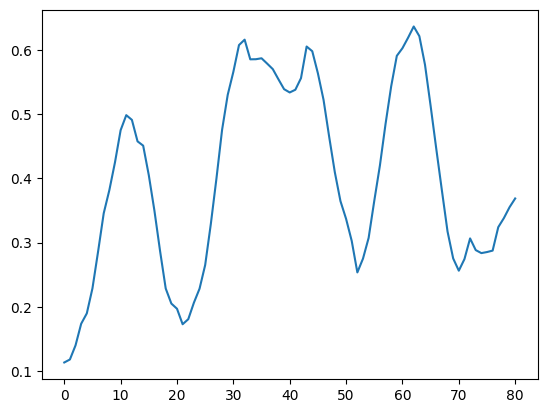

In [15]:
x= segment_mean_speed
plt.plot(y,x)

In [16]:
segment_length=10
step_size=10

# heart rate data 
#heart_rate_data

timestamps = pd.to_datetime(movement_data['timestamp']).apply(lambda x: x.timestamp()).astype(int).to_numpy()

start_time = np.floor(np.min(timestamps))

end_time = start_time + 90
segment_starts = np.arange(start_time, end_time-segment_length+1, step=step_size)
segment_ends = segment_starts + segment_length

segment_mean_center_dist = np.zeros(len(segment_starts))
segment_hr = np.zeros(len(segment_starts))
segment_mean_speed = np.zeros(len(segment_starts))
segment_rmssd = np.zeros(len(segment_starts))
segment_mean_edge_dist = np.zeros(len(segment_starts))

for idx, (start, end) in enumerate(zip(segment_starts, segment_ends)):
    movement_segment = get_segment(movement_data, start, end, timestamps)
    center_dist = get_segment_mean_center_dist(movement_segment, center_point)    
    segment_mean_center_dist[idx] = center_dist
    
    edge_dist = get_segment_mean_edge_dist(movement_segment, corner_points)
    segment_mean_edge_dist[idx] = edge_dist
    
    speed = get_segment_speed(movement_segment)
    segment_mean_speed[idx] = speed
    
    #hr_segment = get_segment(signal, start+5, end+5, heartrate_timestamps)
    
    #hr = get_segment_heart_rate(hr_segment)
    #segment_hr[idx] = hr
    
    #rmssd = get_segment_rmssd(hr_segment)
    #segment_rmssd[idx] = rmssd
    

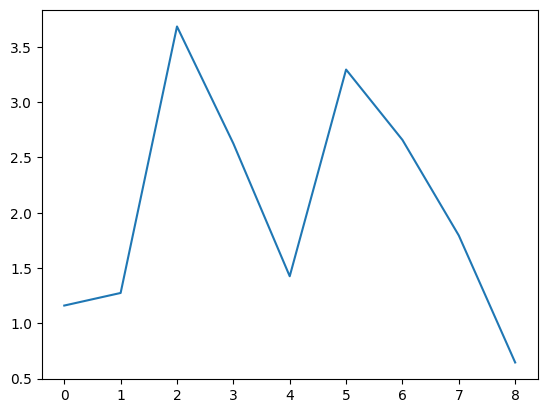

In [17]:
x=segment_mean_center_dist
y= np.arange(9)

plt.plot(y,x)

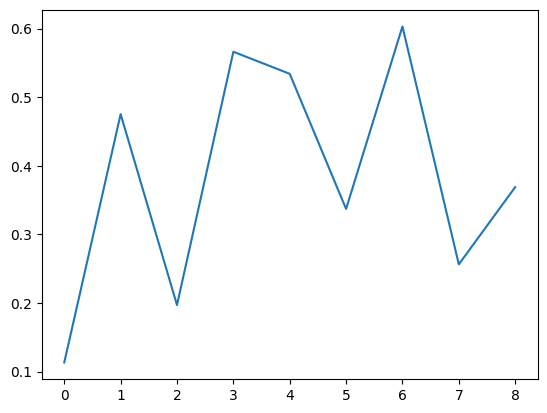

In [18]:
x= segment_mean_speed
plt.plot(y,x)

In [19]:
from scipy.stats import pearsonr
pearsonr(a,b)

PearsonRResult(statistic=np.float64(0.7133273840776647), pvalue=np.float64(0.02054745298027212))

In [20]:
from scipy.stats import pearsonr

print(pearsonr(segment_mean_center_dist, segment_rmssd))

PearsonRResult(statistic=np.float64(nan), pvalue=np.float64(nan))


C:\Users\lal\AppData\Local\Temp\ipykernel_22700\1826523650.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  print(pearsonr(segment_mean_center_dist, segment_rmssd))


In [21]:
print(pearsonr(segment_mean_speed, segment_rmssd))

PearsonRResult(statistic=np.float64(nan), pvalue=np.float64(nan))


C:\Users\lal\AppData\Local\Temp\ipykernel_22700\1765231116.py:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  print(pearsonr(segment_mean_speed, segment_rmssd))


In [22]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Reshape each array to ensure they're column vectors
segment_mean_center_dist = segment_mean_center_dist.reshape(-1, 1)
segment_mean_speed = segment_mean_speed.reshape(-1, 1)
segment_rmssd = segment_rmssd.reshape(-1, 1)

# Combine the features into a single matrix
X = np.hstack((segment_mean_center_dist, segment_mean_speed))

# Initialize the model and fit
linear = LinearRegression()
results = linear.fit(X, segment_rmssd)

# Print the coefficients, intercept, and R-squared
print("Coefficients:", results.coef_[0])  # Coefficients for each feature
print("Intercept:", results.intercept_[0])  # Intercept of the model
print("R-squared:", results.score(X, segment_rmssd))


Coefficients: [0. 0.]
Intercept: 0.0
R-squared: 1.0


In [23]:
print("Length of segment_mean_center_dist:", len(segment_mean_center_dist))
print("Length of segment_mean_speed:", len(segment_mean_speed))
print("Length of segment_rmssd:", len(segment_rmssd))

Length of segment_mean_center_dist: 9
Length of segment_mean_speed: 9
Length of segment_rmssd: 9


### multiple participants' analysis

In [ ]:
from plotting_utils import plot_movement_trajectory_with_layout
import os
import pandas as pd
import numpy as np
from biosppy.signals.tools import filter_signal
import biosppy.signals.ecg as ecg
from calculations import calculate_total_rotation, df_diff
from geometry_utils import mean_edge_distance, mean_center_distance
import glob

def find_latest_ecg_directory(base_dir, participant_id):
    """Find the most recent ECG data directory for a participant"""
    ecg_path_pattern = os.path.join(base_dir, str(participant_id), 'virtual_reality', 'BBT-BIO-AAB*')
    ecg_dirs = glob.glob(ecg_path_pattern)
    if not ecg_dirs:
        return None
    # Sort by directory name (which contains timestamp) and take the latest
    return max(ecg_dirs)

def process_single_trial(movement_path, ecg_dir, center_point, corner_points):
    try:
        # Load movement data
        movement_data = pd.read_csv(movement_path)
        
        # Load ECG data if available
        ecg_data = None
        rmssd = None
        if ecg_dir and os.path.exists(ecg_dir):
            ecg_path = os.path.join(ecg_dir, 'ExG [1].csv')
            utc_path = os.path.join(ecg_dir, 'UTC.csv')
            
            if os.path.exists(ecg_path) and os.path.exists(utc_path):
                heartrate_data = pd.read_csv(ecg_path)
                utc_df = pd.read_csv(utc_path)
                
                timestamp_diff = (utc_df['utc_timestamp']-utc_df['steady_timestamp']).astype(int).to_numpy()[0]
                heartrate_timestamps = ((heartrate_data['steady_timestamp'] + timestamp_diff)/1e6).astype(int).to_numpy()
                
                ecg_signal = heartrate_data['ExG [1]-ch1']
                signal = preprocess_ecg(ecg_signal, 250)
                r_peaks = find_r_peaks(signal, 250)
                rmssd = calculate_rmssd(r_peaks, 250)
                rr_intervals = np.diff(r_peaks) / 250 #sampling rate
                bpm = 60 / np.mean(rr_intervals)
        
        # Process timestamps
        timestamps = pd.to_datetime(movement_data['timestamp']).apply(lambda x: x.timestamp()).astype(int).to_numpy()

        # Setup time windows
        segment_length = 10
        step_size = 1
        start_time = np.floor(np.min(timestamps))
        end_time = start_time + 90
        segment_starts = np.arange(start_time, end_time-segment_length+1, step=step_size)
        segment_ends = segment_starts + segment_length

        # Initialize arrays for metrics
        segment_mean_center_dist = np.zeros(len(segment_starts))
        segment_mean_speed = np.zeros(len(segment_starts))
        segment_mean_edge_dist = np.zeros(len(segment_starts))

        # Process segments
        for idx, (start, end) in enumerate(zip(segment_starts, segment_ends)):
            movement_segment = get_segment(movement_data, start, end, timestamps)
            heart_segment= get_segment(signal, start, end, heartrate_timestamps)
            segment_mean_center_dist[idx] = get_segment_mean_center_dist(movement_segment, center_point)
            segment_mean_edge_dist[idx] = get_segment_mean_edge_dist(movement_segment, corner_points)
            segment_mean_speed[idx] = get_segment_speed(movement_segment)
            segment_mean_acc[idx]= get_segment_acceleration(movement_segment)
            segment_rmssd[idx] = get_segment_rmssd(heart_segment, 250)
            segment_hr[idx] = get_segment_heart_rate(heart_segment, 250)

        return {
            'center_dist': segment_mean_center_dist,
            'edge_dist': segment_mean_edge_dist,
            'speed': segment_mean_speed,
            'timestamps': segment_starts,
            'acceleration': segment_mean_acc,
            'rmssd': segment_rmssd,
            'hr': segment_hr
        }
    except Exception as e:
        print(f"Error processing file {movement_path}: {str(e)}")
        return None

def process_participant_trials(base_dir, participant_id, session_id, trials, center_point, corner_points):
    results = {}
    
    # Find ECG directory for this participant
    ecg_dir = find_latest_ecg_directory(base_dir, participant_id)
    
    for trial in trials:
        movement_path = os.path.join(base_dir, str(participant_id), 'virtual_reality', 
                                   f'S{session_id:03d}', 'trackers', 
                                   f'camera_movement_T{trial:03d}.csv')
        
        if os.path.exists(movement_path):
            try:
                trial_results = process_single_trial(movement_path, ecg_dir, center_point, corner_points)
                if trial_results is not None:
                    results[trial] = trial_results
                    print(f"Successfully processed participant {participant_id} session {session_id} trial {trial}")
            except Exception as e:
                print(f"Error processing participant {participant_id} session {session_id} trial {trial}: {str(e)}")
        else:
            print(f"File not found: {movement_path}")
    
    return results

def process_all_participants(base_dir, participant_sessions, trials):
    center_point = np.array((-7,5))
    corner_points = np.array([(-4,2),(-9,2),(-9,9),(-4,9)])
    
    all_results = {}
    aggregated_metrics = {
        'center_dist': [],
        'edge_dist': [],
        'speed': [],
        'rmssd': [],
        'hr':[],
        'acceleration':[],
    }
    
    # Process each participant
    for participant_id, session_id in participant_sessions:
        all_results[participant_id] = process_participant_trials(
            base_dir, participant_id, session_id, trials, center_point, corner_points)
        
        # Calculate participant averages
        participant_metrics = {
            'center_dist': [],
            'edge_dist': [],
            'speed': [],
            'rmssd': [],
            'hr':[],
            'acceleration':[]
        }
        
        for trial_data in all_results[participant_id].values():
            participant_metrics['center_dist'].append(np.mean(trial_data['center_dist']))
            participant_metrics['edge_dist'].append(np.mean(trial_data['edge_dist']))
            participant_metrics['speed'].append(np.mean(trial_data['speed']))
            participant_metrics['hr'].append(np.mean(trial_data['hr']))
            participant_metrics['acceleration'].append(np.mean(trial_data['acceleration']))
            if trial_data['rmssd'] is not None:
                participant_metrics['rmssd'].append(trial_data['rmssd'])
        
        # Add participant averages to aggregated metrics
        for metric in aggregated_metrics:
            if participant_metrics[metric]:  # Only if we have data for this participant
                aggregated_metrics[metric].append(np.mean(participant_metrics[metric]))
    
    # Calculate overall averages and standard deviations
    final_metrics = {
        metric: {
            'mean': np.mean(values) if values else None,
            'std': np.std(values) if values else None,
            'individual_values': values
        }
        for metric, values in aggregated_metrics.items()
    }
    
    return all_results, final_metrics

# Example usage:
base_dir = r"C:\Users\lal\Documents\tez\virtualreality_data_version1"
participant_sessions = [
    (845, 1),
    (478, 2),
    # Add more participants and their session numbers here
]
trials = [7, 11, 15] 

all_results, final_metrics = process_all_participants(base_dir, participant_sessions, trials)

# Print overall results
print("\nOverall Results:")
for metric, stats in final_metrics.items():
    print(f"\n{metric}:")
    print(f"Mean: {stats['mean']:.3f}" if stats['mean'] is not None else "Mean: No data")
    print(f"Std: {stats['std']:.3f}" if stats['std'] is not None else "Std: No data")
    print("Individual participant means:", stats['individual_values'])

Successfully processed participant 845 session 1 trial 7
Successfully processed participant 845 session 1 trial 11
Successfully processed participant 845 session 1 trial 15
Successfully processed participant 478 session 2 trial 7
Successfully processed participant 478 session 2 trial 11
Successfully processed participant 478 session 2 trial 15

Overall Results:

center_dist:
Mean: 1.938
Std: 0.018
Individual participant means: [np.float64(1.9553630702714784), np.float64(1.9200978772672663)]

edge_dist:
Mean: 0.677
Std: 0.010
Individual participant means: [np.float64(0.6865620329959453), np.float64(0.6674979829958946)]

speed:
Mean: 0.268
Std: 0.032
Individual participant means: [np.float64(0.2367695090934259), np.float64(0.2998810363326809)]

rmssd:
Mean: 54.126
Std: 16.777
Individual participant means: [np.float64(37.349083680810125), np.float64(70.90365063960931)]

hr:
Mean: 77.612
Std: 2.551
Individual participant means: [np.float64(75.06077541916243), np.float64(80.16227364413118)]

### multiple participant analysis

In [36]:
from plotting_utils import plot_movement_trajectory_with_layout
import os
import pandas as pd
import numpy as np
from biosppy.signals.tools import filter_signal
import biosppy.signals.ecg as ecg
from calculations import calculate_total_rotation, df_diff, calculate_accelerations
from geometry_utils import mean_edge_distance, mean_center_distance
import glob

def find_latest_ecg_directory(base_dir, participant_id):
    """Find the most recent ECG data directory for a participant"""
    ecg_path_pattern = os.path.join(base_dir, str(participant_id), 'virtual_reality', 'BBT-BIO-AAB*')
    ecg_dirs = glob.glob(ecg_path_pattern)
    if not ecg_dirs:
        return None
    return max(ecg_dirs)

def process_single_trial(movement_path, ecg_dir, center_point, corner_points):
    try:
        # Load movement data
        if not os.path.exists(movement_path):
            print(f"Movement file not found: {movement_path}")
            return None
            
        movement_data = pd.read_csv(movement_path)
        if movement_data.empty:
            print(f"Empty movement data file: {movement_path}")
            return None

        # Load ECG data if available
        ecg_data = None
        rmssd = None
        if ecg_dir and os.path.exists(ecg_dir):
            ecg_path = os.path.join(ecg_dir, 'ExG [1].csv')
            utc_path = os.path.join(ecg_dir, 'UTC.csv')
            
            if os.path.exists(ecg_path) and os.path.exists(utc_path):
                try:
                    heartrate_data = pd.read_csv(ecg_path)
                    utc_df = pd.read_csv(utc_path)
                    
                    if not heartrate_data.empty and not utc_df.empty:
                        timestamp_diff = (utc_df['utc_timestamp']-utc_df['steady_timestamp']).astype(int).to_numpy()[0]
                        heartrate_timestamps = ((heartrate_data['steady_timestamp'] + timestamp_diff)/1e6).astype(int).to_numpy()
                        
                        ecg_signal = heartrate_data['ExG [1]-ch1']
                        signal = preprocess_ecg(ecg_signal, 250)
                        r_peaks = find_r_peaks(signal, 250)
                        rmssd = calculate_rmssd(r_peaks, 250)
                        rr_intervals = np.diff(r_peaks) / 250 #sampling rate
                        bpm = 60 / np.mean(rr_intervals)
                except Exception as e:
                    print(f"Error processing ECG data: {str(e)}")
                    rmssd = None

        # Process timestamps
        timestamps = pd.to_datetime(movement_data['timestamp']).apply(lambda x: x.timestamp()).astype(int).to_numpy()
        if len(timestamps) == 0:
            print(f"No valid timestamps in file: {movement_path}")
            return None

        # Setup time windows
        segment_length = 10
        step_size = 5
        start_time = np.floor(np.min(timestamps))
        end_time = start_time + 90
        segment_starts = np.arange(start_time, end_time-segment_length+1, step=step_size)
        segment_ends = segment_starts + segment_length

        # Initialize arrays for metrics
        segment_mean_center_dist = np.zeros(len(segment_starts))
        segment_mean_speed = np.zeros(len(segment_starts))
        segment_mean_edge_dist = np.zeros(len(segment_starts))
        segment_mean_acc = np.zeros(len(segment_starts))
        segment_stops_count = np.zeros(len(segment_starts))
        segment_stops_duration = np.zeros(len(segment_starts))
        segment_max_distance = np.zeros(len(segment_starts))
        segment_rmssd = np.zeros(len(segment_starts))
        segment_hr = np.zeros(len(segment_starts))

        # Process segments
        valid_segments = 0
        for idx, (start, end) in enumerate(zip(segment_starts, segment_ends)):
            movement_segment = get_segment(movement_data, start, end, timestamps)
            heart_segment= get_segment(signal, start, end, heartrate_timestamps)
            segment_rmssd[idx] = get_segment_rmssd(heart_segment, 250)
            segment_hr[idx] = get_segment_heart_rate(heart_segment, 250)
            if len(movement_segment) > 0:
                segment_mean_center_dist[idx] = get_segment_mean_center_dist(movement_segment, center_point)
                segment_mean_edge_dist[idx] = get_segment_mean_edge_dist(movement_segment, corner_points)
                segment_mean_speed[idx] = get_segment_speed(movement_segment)
                segment_mean_acc[idx]= get_segment_acceleration(movement_segment)
                segment_stops_count[idx] = get_segment_stops_count(movement_segment, stop_threshold=0.10, stop_duration_threshold=2.0)
                segment_stops_duration[idx] = get_segment_stops_duration(movement_segment, stop_threshold=0.10, stop_duration_threshold=2.0)
                segment_max_distance[idx] = get_max_distance(movement_segment)
                
                valid_segments += 1
            else:
                segment_mean_center_dist[idx] = np.nan
                segment_mean_edge_dist[idx] = np.nan
                segment_mean_speed[idx] = np.nan

        if valid_segments == 0:
            print(f"No valid segments found in file: {movement_path}")
            return None

        return {
            'center_dist': segment_mean_center_dist[~np.isnan(segment_mean_center_dist)],
            'edge_dist': segment_mean_edge_dist[~np.isnan(segment_mean_edge_dist)],
            'speed': segment_mean_speed[~np.isnan(segment_mean_speed)],
            'acceleration': segment_mean_acc[~np.isnan(segment_mean_acc)],
            'timestamps': segment_starts,
            'rmssd': segment_rmssd,
            'stops_count': segment_stops_count,
            'stops_duration': segment_stops_duration,
            'max_distance': segment_max_distance,
            'hr': segment_hr
        }
    except Exception as e:
        print(f"Error processing file {movement_path}: {str(e)}")
        return None

def process_participant_trials(base_dir, participant_id, session_id, trials, center_point, corner_points):
    results = {}
    
    # Find ECG directory for this participant
    ecg_dir = find_latest_ecg_directory(base_dir, participant_id)
    
    for trial in trials:
        movement_path = os.path.join(base_dir, str(participant_id), 'virtual_reality', 
                                   f'S{session_id:03d}', 'trackers', 
                                   f'camera_movement_T{trial:03d}.csv')
        
        if os.path.exists(movement_path):
            try:
                trial_results = process_single_trial(movement_path, ecg_dir, center_point, corner_points)
                if trial_results is not None:
                    results[trial] = trial_results
                    print(f"Successfully processed participant {participant_id} session {session_id} trial {trial}")
            except Exception as e:
                print(f"Error processing participant {participant_id} session {session_id} trial {trial}: {str(e)}")
        else:
            print(f"File not found: {movement_path}")
    
    return results

def organize_trial_results(all_results):
    # Create dictionaries to store organized data
    trial_summaries = {}
    participant_data = {}
    
    # DataFrame for detailed segment-level data
    segment_data_list = []
    
    for trial_num in [7, 11, 15]:
        trial_summaries[trial_num] = {
            'center_dist': [],
            'edge_dist': [],
            'speed': [],
            'acceleration': [],
            'stops_count': [],
            'stops_duration': [],
            'max_distance':[],
            'rmssd': [],
            'hr':[]
        }
        
        for participant_id in all_results:
            if trial_num in all_results[participant_id]:
                trial_data = all_results[participant_id][trial_num]
                if trial_data is not None:
                    # Store participant-level means for this trial
                    participant_key = (participant_id, trial_num)
                    participant_data[participant_key] = {
                        'participant_id': participant_id,
                        'trial': trial_num,
                        'center_dist_mean': np.mean(trial_data['center_dist']),
                        'edge_dist_mean': np.mean(trial_data['edge_dist']),
                        'speed_mean': np.mean(trial_data['speed']),
                        'acceleration_mean': np.mean(trial_data['acceleration']),
                        'stops_count_mean': np.mean(trial_data['stops_count']),
                        'stops_duration_mean': np.mean(trial_data['stops_duration']),
                        'max_distance_mean': np.mean(trial_data['max_distance']),
                        'rmssd': trial_data['rmssd'],
                        'hr':trial_data['hr']
                    }
                    
                    # Collect trial-level data
                    trial_summaries[trial_num]['center_dist'].extend(trial_data['center_dist'])
                    trial_summaries[trial_num]['edge_dist'].extend(trial_data['edge_dist'])
                    trial_summaries[trial_num]['speed'].extend(trial_data['speed'])
                    trial_summaries[trial_num]['acceleration'].extend(trial_data['acceleration'])
                    trial_summaries[trial_num]['stops_count'].extend(trial_data['stops_count'])
                    trial_summaries[trial_num]['stops_duration'].extend(trial_data['stops_duration'])
                    trial_summaries[trial_num]['max_distance'].extend(trial_data['max_distance'])
                    trial_summaries[trial_num]['hr'].extend(trial_data['hr'])
                    if trial_data['rmssd'] is not None:
                        trial_summaries[trial_num]['rmssd'].append(trial_data['rmssd'])
                    
                    # Store segment-level data
                    for seg_idx, (center_d, edge_d, speed, acc, stops_count, stops_duration, max_distance, rmssd, hr) in enumerate(zip(
                            trial_data['center_dist'],
                            trial_data['edge_dist'],
                            trial_data['speed'],
                            trial_data['acceleration'],
                            trial_data['stops_count'],
                            trial_data['stops_duration'],
                            trial_data['max_distance'],
                            trial_data['rmssd'],
                            trial_data['hr'])):
                        segment_data_list.append({
                            'participant_id': participant_id,
                            'trial': trial_num,
                            'segment': seg_idx,
                            'center_dist': center_d,
                            'edge_dist': edge_d,
                            'speed': speed,
                            'acceleration':acc,
                            'stops_count': stops_count,
                            'stops_duration': stops_duration,
                            'max_distance': max_distance,
                            'rmssd':rmssd,
                            'hr':hr
                        })

    # Create DataFrames
    df_participant = pd.DataFrame.from_dict(participant_data, orient='index')
    df_segments = pd.DataFrame(segment_data_list)
    
    # Trial-level summary
    trial_summary_data = []
    for trial_num, data in trial_summaries.items():
        trial_summary_data.append({
            'trial': trial_num,
            'center_dist_mean': np.mean(data['center_dist']),
            'center_dist_std': np.std(data['center_dist']),
            'edge_dist_mean': np.mean(data['edge_dist']),
            'edge_dist_std': np.std(data['edge_dist']),
            'speed_mean': np.mean(data['speed']),
            'speed_std': np.std(data['speed']),
            'acceleration_mean': np.mean(data['acceleration']),
            'acceleration_std': np.std(data['acceleration']),
            'rmssd_mean': np.mean(data['rmssd']) if data['rmssd'] else None,
            'rmssd_std': np.std(data['rmssd']) if data['rmssd'] else None
        })
    df_trial_summary = pd.DataFrame(trial_summary_data)

    return {
        'participant_summary': df_participant,
        'trial_summary': df_trial_summary,
        'segment_data': df_segments,
        'raw_data': all_results
    }

def print_trial_separated_results(all_results, final_metrics):
    print("\nRESULTS SEPARATED BY TRIAL:")
    
    for trial_num in [7, 11, 15]:
        print(f"\n=== TRIAL T{trial_num:03d} ===")
        
        # Collect all data for this trial
        trial_center_dists = []
        trial_edge_dists = []
        trial_speeds = []
        trial_accelerations = []
        trial_stops_count = []
        trial_stops_duration = []
        trial_max_distance = []
        trial_rmssds = []
        trial_hrs=[]
        
        print(f"\nParticipant-specific results for T{trial_num:03d}:")
        for participant_id in all_results:
            if trial_num in all_results[participant_id]:
                trial_data = all_results[participant_id][trial_num]
                if trial_data is not None:
                    participant_center_mean = np.mean(trial_data['center_dist'])
                    participant_edge_mean = np.mean(trial_data['edge_dist'])
                    participant_speed_mean = np.mean(trial_data['speed'])
                    participant_acceleration_mean = np.mean(trial_data['acceleration'])
                    participant_stop_count_mean= np.mean(trial_data['stops_count'])
                    participant_stop_duration_mean= np.mean(trial_data['stops_duration'])
                    participant_max_distance_mean= np.mean(trial_data['max_distance'])
                    participant_rmssd = np.mean(trial_data['rmssd'])
                    participant_hr=np.mean(trial_data['hr'])
                    
                    print(f"\nParticipant {participant_id}:")
                    print(f"Center Distance Mean: {participant_center_mean:.3f}")
                    print(f"Edge Distance Mean: {participant_edge_mean:.3f}")
                    print(f"Speed Mean: {participant_speed_mean:.3f}")
                    print(f"Acceleration Mean: {participant_acceleration_mean:.3f}")
                    print(f"Stops Count Mean: {participant_stop_count_mean:.3f}")
                    print(f"Stops Duration Mean: {participant_stop_duration_mean:.3f}")
                    print(f"Max Distance Mean: {participant_max_distance_mean:.3f}")
                    print(f"HR Mean: {participant_hr:.3f}")
                    if trial_data['rmssd'] is not None:
                        print(f"RMSSD: {participant_rmssd:.3f}")
                    
                    # Collect data for trial averages
                    trial_center_dists.extend(trial_data['center_dist'])
                    trial_edge_dists.extend(trial_data['edge_dist'])
                    trial_speeds.extend(trial_data['speed'])
                    trial_accelerations.extend(trial_data['acceleration'])
                    trial_stops_count.extend(trial_data['stops_count'])
                    trial_stops_duration.extend(trial_data['stops_duration'])
                    trial_max_distance.extend(trial_data['max_distance'])
                    trial_hrs.extend(trial_data['hr'])
                    if trial_data['rmssd'] is not None:
                        trial_rmssds.append(trial_data['rmssd'])
        
        # Print trial averages
        print(f"\nOverall averages for T{trial_num:03d}:")
        if trial_center_dists:
            print(f"Center Distance: Mean = {np.mean(trial_center_dists):.3f}, Std = {np.std(trial_center_dists):.3f}")
        if trial_edge_dists:
            print(f"Edge Distance: Mean = {np.mean(trial_edge_dists):.3f}, Std = {np.std(trial_edge_dists):.3f}")
        if trial_speeds:
            print(f"Speed: Mean = {np.mean(trial_speeds):.3f}, Std = {np.std(trial_speeds):.3f}")
        if trial_accelerations:
            print(f"Acceleration: Mean = {np.mean(trial_accelerations):.3f}, Std = {np.std(trial_accelerations):.3f}")
        if trial_rmssds:
            print(f"RMSSD: Mean = {np.mean(trial_rmssds):.3f}, Std = {np.std(trial_rmssds):.3f}")
        if trial_hrs:
            print(f"HR: Mean = {np.mean(trial_hrs):.3f}, Std = {np.std(trial_hrs):.3f}")

def process_all_participants(base_dir, participant_sessions, trials):
    center_point = np.array((-7,5))
    corner_points = np.array([(-4,2),(-9,2),(-9,9),(-4,9)])
    
    all_results = {}
    aggregated_metrics = {
        'center_dist': [],
        'edge_dist': [],
        'speed': [],
        'stops_count': [],
        'stops_duration': [],
        'max_distance':[],
        'rmssd': [],
        'hr':[],
        'acceleration':[],
    }
    
    # Process each participant
    for participant_id, session_id in participant_sessions:
        all_results[participant_id] = process_participant_trials(
            base_dir, participant_id, session_id, trials, center_point, corner_points)
        
        # Calculate participant averages
        participant_metrics = {
            'center_dist': [],
            'edge_dist': [],
            'speed': [],
            'rmssd': [],
            'stops_count':[],
            'stops_duration':[],
            'max_distance':[],
            'hr':[],
            'acceleration':[]
        }
        
        for trial_data in all_results[participant_id].values():
            participant_metrics['center_dist'].append(np.mean(trial_data['center_dist']))
            participant_metrics['edge_dist'].append(np.mean(trial_data['edge_dist']))
            participant_metrics['speed'].append(np.mean(trial_data['speed']))
            participant_metrics['hr'].append(np.mean(trial_data['hr']))
            participant_metrics['stops_count'].append(np.mean(trial_data['stops_count']))
            participant_metrics['stops_duration'].append(np.mean(trial_data['stops_duration']))
            participant_metrics['acceleration'].append(np.mean(trial_data['acceleration']))
            participant_metrics['max_distance'].append(np.mean(trial_data['max_distance']))
            if trial_data['rmssd'] is not None:
                participant_metrics['rmssd'].append(trial_data['rmssd'])
        
        # Add participant averages to aggregated metrics
        for metric in aggregated_metrics:
            if participant_metrics[metric]:  # Only if we have data for this participant
                aggregated_metrics[metric].append(np.mean(participant_metrics[metric]))
    
    # Calculate overall averages and standard deviations
    final_metrics = {
        metric: {
            'mean': np.mean(values) if values else None,
            'std': np.std(values) if values else None,
            'individual_values': values
        }
        for metric, values in aggregated_metrics.items()
    }
    
    return all_results, final_metrics


# Main execution
def main():
    # Setup parameters
    base_dir = r"C:\Users\lal\Documents\tez\virtualreality_data_version1"
    participant_sessions = [
        (845, 1),
        (478, 2),
        (578, 2),
        (352, 1),
        (401, 1),
        (2, 1)
    ]
    trials = [7, 15]
    center_point = np.array((-7,5))
    corner_points = np.array([(-4,2),(-9,2),(-9,9),(-4,9)])

    # Process all data
    all_results, final_metrics = process_all_participants(base_dir, participant_sessions, trials)
    
    # Print detailed results by trial
    print_trial_separated_results(all_results, final_metrics)
    
    # Organize and store results in DataFrames
    results_data = organize_trial_results(all_results)
    
    # Print DataFrame summaries
    print("\nTrial Summary DataFrame:")
    print(results_data['trial_summary'])
    
    print("\nParticipant Summary DataFrame:")
    print(results_data['participant_summary'])
    
    print("\nSegment Data DataFrame Preview:")
    print(results_data['segment_data'].head())
    
    # Optional: Save DataFrames to CSV
    results_data['trial_summary'].to_csv('trial_summary.csv')
    results_data['participant_summary'].to_csv('participant_summary.csv')
    results_data['segment_data'].to_csv('segment_data.csv')
    
    return results_data

if __name__ == "__main__":
    results_data = main()

# Access different DataFrames
trial_summary = results_data['trial_summary']
participant_summary = results_data['participant_summary']
segment_data = results_data['segment_data']



Successfully processed participant 845 session 1 trial 7
Successfully processed participant 845 session 1 trial 15
Successfully processed participant 478 session 2 trial 7
Successfully processed participant 478 session 2 trial 15
Successfully processed participant 578 session 2 trial 7
Successfully processed participant 578 session 2 trial 15
Successfully processed participant 352 session 1 trial 7
Successfully processed participant 352 session 1 trial 15
Successfully processed participant 401 session 1 trial 7
Successfully processed participant 401 session 1 trial 15
Successfully processed participant 2 session 1 trial 7
Successfully processed participant 2 session 1 trial 15

RESULTS SEPARATED BY TRIAL:

=== TRIAL T007 ===

Participant-specific results for T007:

Participant 845:
Center Distance Mean: 1.978
Edge Distance Mean: 0.845
Speed Mean: 0.314
Acceleration Mean: 0.353
Stops Count Mean: 0.176
Stops Duration Mean: 0.731
Max Distance Mean: 2.679
HR Mean: 76.894
RMSSD: 32.834

Par

c:\Users\lal\Documents\tez\analysis\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\lal\Documents\tez\analysis\.venv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\lal\Documents\tez\analysis\.venv\Lib\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\lal\Documents\tez\analysis\.venv\Lib\site-packages\numpy\_core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\lal\Documents\tez\analysis\.venv\Lib\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [36]:
trial_summary

,trial,center_dist_mean,center_dist_std,edge_dist_mean,edge_dist_std,speed_mean,speed_std,acceleration_mean,acceleration_std,rmssd_mean,rmssd_std
0,7,2.097609,0.528011,0.817836,0.364263,0.358085,0.234841,0.298895,0.282448,72.005064,70.930446
1,11,1.677407,0.699004,0.611036,0.383923,0.259808,0.160037,0.028718,0.050226,109.640079,183.929766
2,15,2.252345,0.771155,0.755070,0.426141,0.287897,0.132668,0.322888,0.188163,143.715011,128.039938


In [36]:
participant_summary

,,participant_id,trial,center_dist_mean,edge_dist_mean,speed_mean,acceleration_mean,rmssd,hr
845,7,845,7,1.974527,0.850351,0.321001,0.358873,"[25.810498216458708, 24.657656011875904, 21.79...","[73.37953526294334, 73.46938775510203, 74.0907..."
478,7,478,7,2.069810,0.787892,0.272640,0.365058,"[19.008769905844336, 19.845557534273354, 18.47...","[84.96732026143789, 85.29650690495532, 85.3391..."
578,7,578,7,1.961328,0.824233,0.358294,0.206214,"[23.323807579381203, 21.166010488516726, 22.36...","[73.99103139013452, 74.59312839059675, 75.5350..."
352,7,352,7,2.097331,0.749319,0.341347,0.249199,"[178.02471738497437, 162.88400780923828, 171.4...","[99.70918155380141, 99.7506234413965, 100.4604..."
401,7,401,7,2.097331,0.749319,0.341347,0.249199,"[178.02471738497437, 162.88400780923828, 171.4...","[99.70918155380141, 99.7506234413965, 100.4604..."
2,7,2,7,2.385330,0.945903,0.513880,0.364830,"[20.199009876724155, 18.924953002685267, 17.54...","[85.48882069267864, 85.05467800729042, 85.7897..."
845,11,845,11,1.396700,0.526515,0.176941,0.051020,"[29.772470505485433, 38.55385843206877, 38.657...","[67.62295081967211, 67.67842493847415, 67.6784..."
478,11,478,11,1.361589,0.428924,0.237868,0.054409,"[29.46183972531247, 29.597297173897484, 29.348...","[82.87292817679558, 83.54755784061697, 83.4760..."
578,11,578,11,1.911866,0.385838,0.252073,0.011593,"[17.017637908946117, 20.64417153052692, 20.502...","[73.8585496866607, 74.1045697818032, 74.380165..."
352,11,352,11,1.595721,0.855980,0.245817,0.008658,"[170.1293625450939, 148.5010822471386, 145.017...","[89.78195810175289, 89.21490880253765, 89.5140..."


In [26]:
segment_data

,participant_id,trial,segment,center_dist,edge_dist,speed,acceleration,stops_count,stops_duration,max_distance,rmssd,hr
0,845,7,0,2.591027,1.023717,0.034789,0.024580,2.0,7.5267,0.079066,25.810498,73.379535
1,845,7,1,1.747154,0.528427,0.299896,0.251997,0.0,0.0000,2.703729,17.267942,76.174355
2,845,7,2,1.523551,0.557461,0.360725,0.377889,0.0,0.0000,2.838911,9.105443,76.890218
3,845,7,3,1.999914,1.294453,0.378336,0.284939,0.0,0.0000,3.584783,35.614093,75.282309
4,845,7,4,2.103044,0.805932,0.338227,0.357150,0.0,0.0000,2.542488,15.303000,77.186964
...,...,...,...,...,...,...,...,...,...,...,...,...
103,2,15,4,2.368364,1.708993,0.453731,0.370481,0.0,0.0000,3.424775,159.464103,74.024226
104,2,15,5,2.661207,0.975499,0.466641,0.325695,0.0,0.0000,3.518300,191.149156,101.230647
105,2,15,6,2.027536,1.491567,0.245991,0.093461,0.0,0.0000,1.262246,160.215240,90.909091
106,2,15,7,1.469997,1.142667,0.209504,0.249693,0.0,0.0000,1.192532,172.589330,89.935760


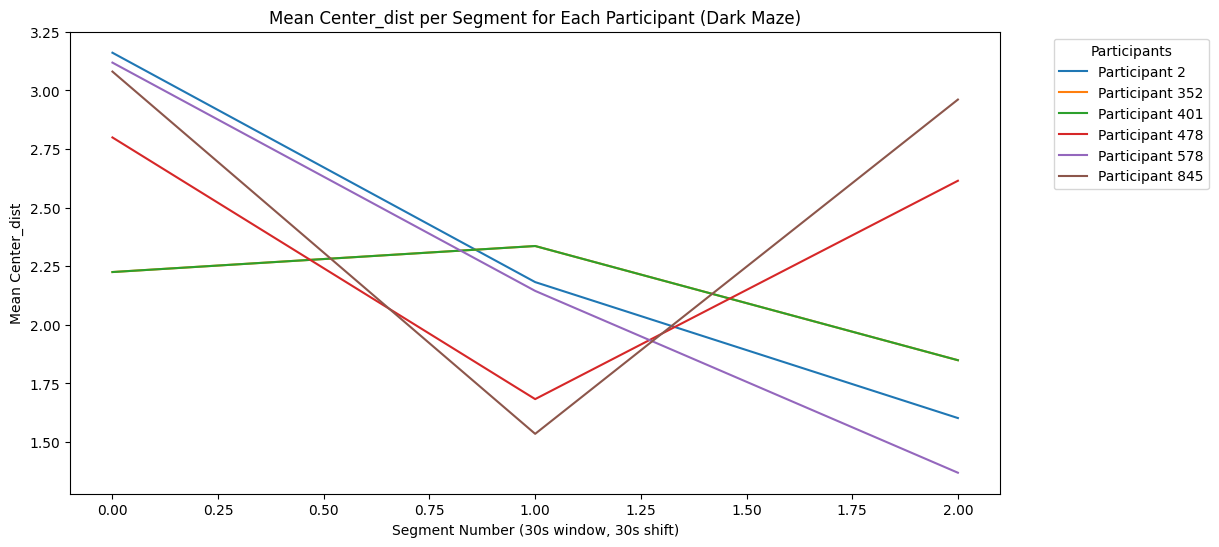

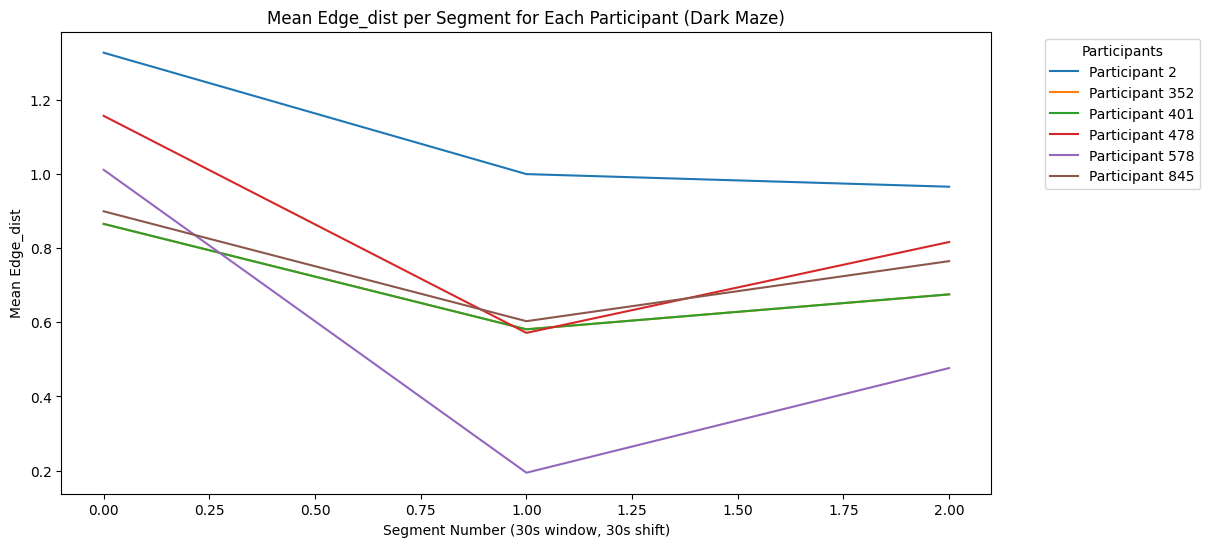

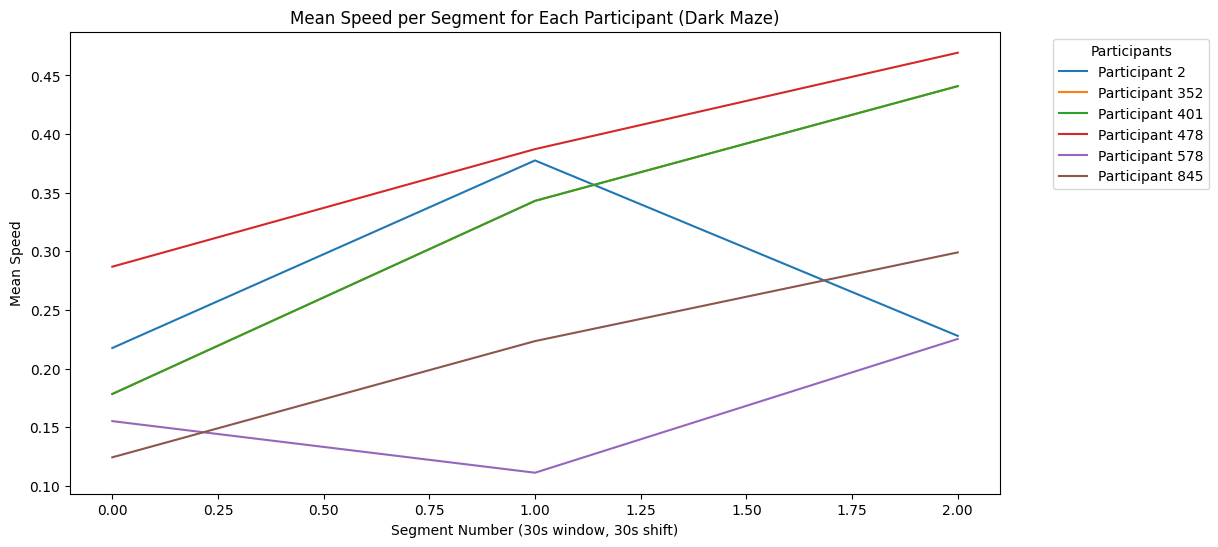

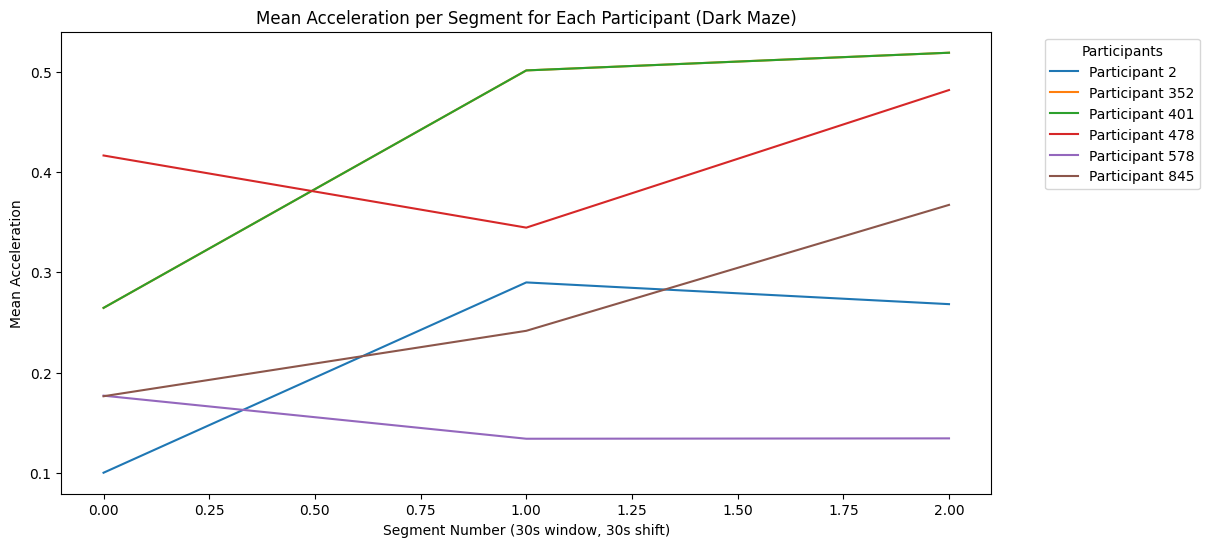

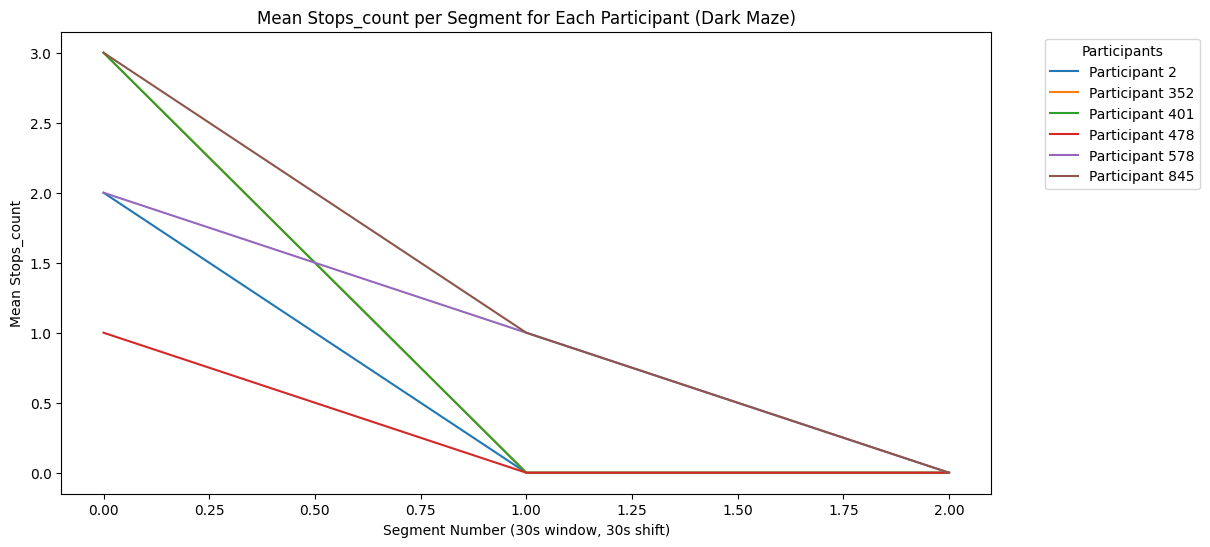

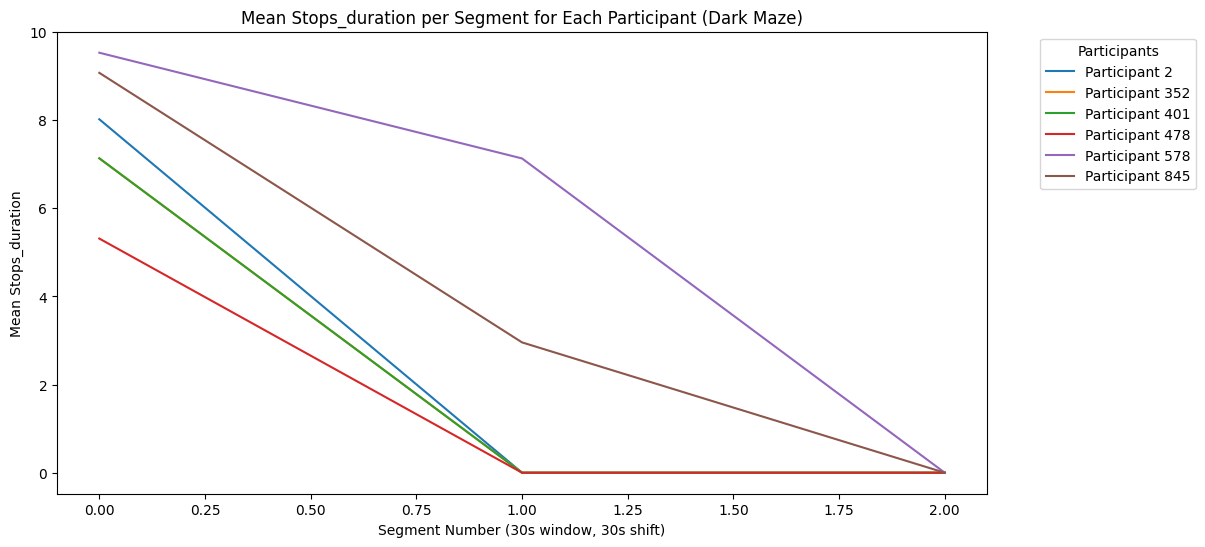

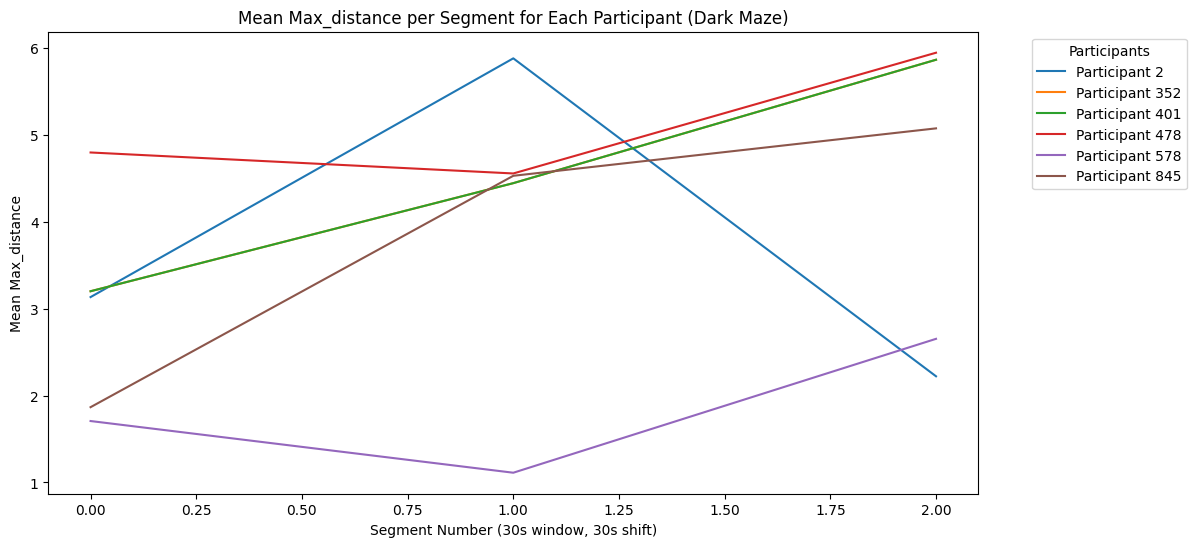

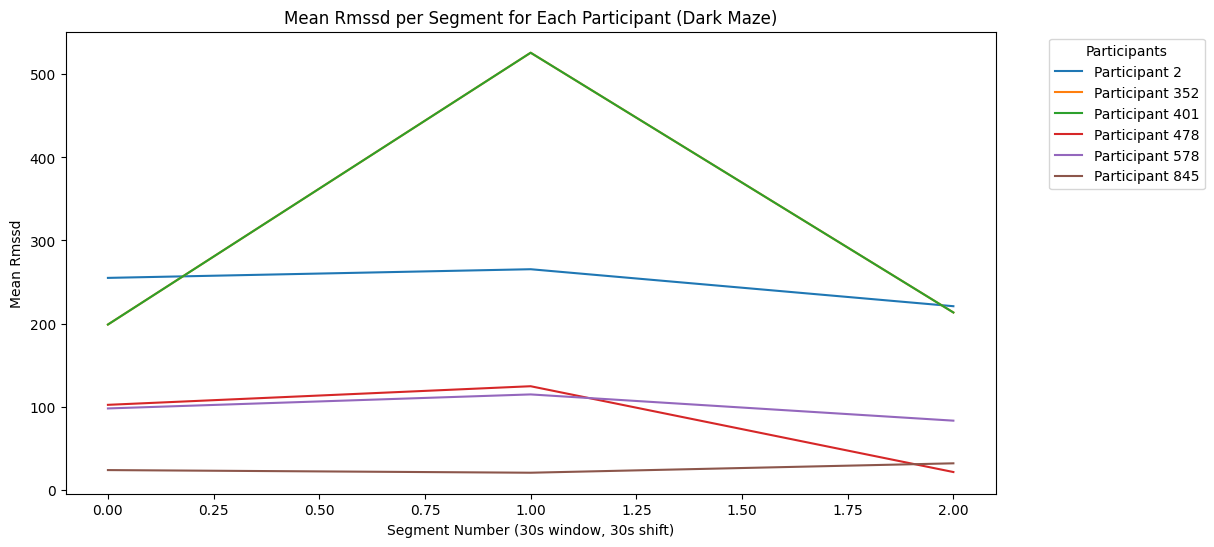

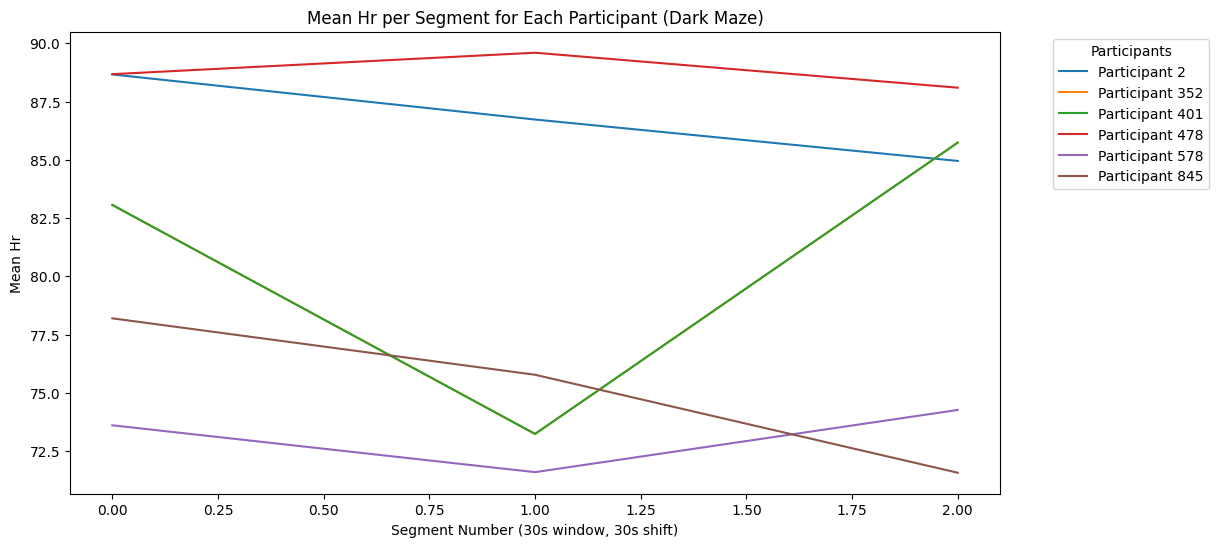

In [35]:
trial_num = 15
trial_7_data = segment_data[segment_data['trial'] == trial_num]
features = ['center_dist', 'edge_dist', 'speed', 'acceleration', 'stops_count', 'stops_duration', 'max_distance', 'rmssd', 'hr']
# Calculate the mean values per segment for each participant within trial 7
participant_segment_means = trial_7_data.groupby(['participant_id', 'segment'])[features].mean().reset_index()

# Define variables to plot (center_dist, edge_dist, speed, acceleration) per segment for each participant
variables_to_plot = ["center_dist", "edge_dist", "speed", "acceleration", 'stops_count', 'stops_duration', 'max_distance', 'rmssd', 'hr']
participants = participant_segment_means['participant_id'].unique()

output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

trial_condition = "Empty Room" if trial_num == 7 else "Dark Maze" if trial_num == 15 else "Unknown Condition"

# Plotting mean distributions per segment for each participant across selected variables
for variable in variables_to_plot:
    plt.figure(figsize=(12, 6))
    for participant in participants:
        participant_data = participant_segment_means[participant_segment_means['participant_id'] == participant]
        plt.plot(participant_data['segment'], participant_data[variable], label=f'Participant {participant}')

    plt.title(f'Mean {variable.capitalize()} per Segment for Each Participant ({trial_condition})')
    plt.xlabel('Segment Number (30s window, 30s shift)')
    plt.ylabel(f'Mean {variable.capitalize()}')
    plt.legend(title='Participants', bbox_to_anchor=(1.05, 1), loc='upper left')

    plot_filename = os.path.join(output_dir, f'trial{trial_num}_{variable}_per_segment_30s_30sshift.png')
    plt.savefig(plot_filename, bbox_inches='tight')  # Save with tight layout

    # Show the plot
    plt.show()
